In [171]:
import numpy as np
import pandas as pd
from spec_id import Median_w_Error_cont, Gauss_dist, Stack_posteriors, Gen_grid
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d
import seaborn as sea
from statsmodels.nonparametric.smoothers_lowess import lowess
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in", "ytick.direction": "in"})
from time import time
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)


import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

In [172]:
ksmooth = importr('KernSmooth')
# IDW =z_g.argsort()
# eres = rzoo.zoo(mill_DB['light_weighted_age'][IDW],mill_DB['z_geo'][IDW])
# rmean = rzoo.rollapply(eres,200,'mean', fill = 'NA', align ='right')
# rstd = rzoo.rollapply(eres,200,'sd', fill = 'NA', align ='right')

In [ ]:
ksmooth.locpoly()

In [2]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
galDB = galDB.query('ids != 14713 and ids != 38126')
lzDB = galDB.query('hi_res_specz < 1.16')
mzDB = galDB.query('1.16 < hi_res_specz < 1.3')
hzDB = galDB.query('1.3 < hi_res_specz < 1.45')
uhzDB = galDB.query('1.45 < hi_res_specz')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [3]:
def Gauss_dist(x, mu, sigma):
    G = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    C = np.trapz(G, x)
    G /= C
    return G

In [4]:
x=np.arange(0,6,0.01)
ers = np.arange(0,1.5,0.001)
gdist = Gauss_dist(x,3,.75)
sp_size = 12

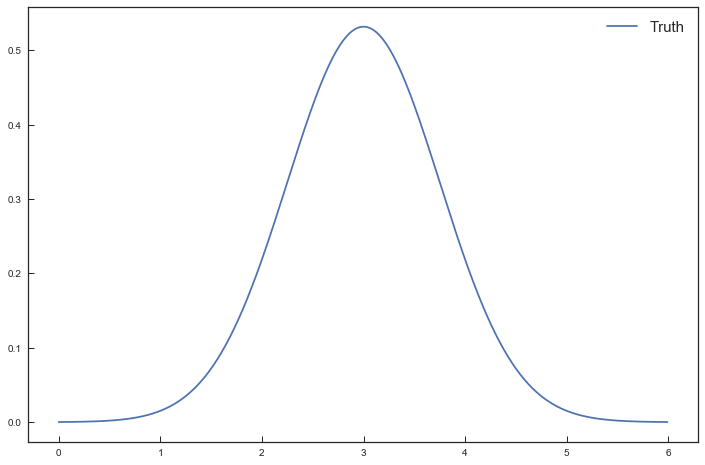

In [5]:
%matplotlib inline
plt.figure(figsize=[12,8])
plt.plot(x,gdist,label='Truth')
plt.legend(fontsize=15)

In [523]:
dist_grid= np.zeros([sp_size,x.size])
for i in range(sp_size):
    dist_grid[i] = Gauss_dist(x,np.random.normal(3,.75),np.random.choice(ers))

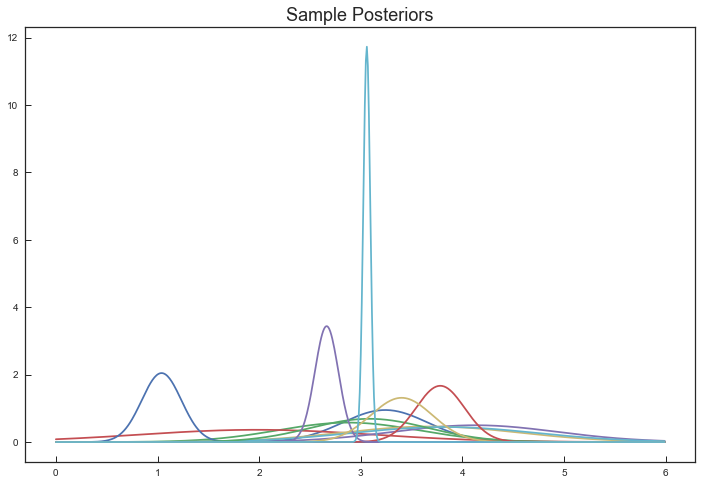

In [524]:
plt.figure(figsize=[12,8])
for i in range(sp_size):
    plt.plot(x,dist_grid[i])
plt.title('Sample Posteriors', fontsize =18)

In [525]:
def Iterate_stack(grid_o,x_o,its):
    del_x = x_o[1] - x_o[0]
    x_ext = np.append(np.append(x_o[0] - del_x,x_o),x_o[-1] + del_x)
    
    grid_ext = np.zeros([len(grid_o),x_ext.size])
    
    for i in range(len(grid_o)):
        grid_ext[i] = np.append(np.append(0,grid_o[i]),0)
    
    x = np.linspace(x_o[0],x_o[-1],1000)
    grid = np.zeros([len(grid_o),x.size])
        
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_ext,grid_ext[i])(x)
    
    
    sumpos = np.array(sum(grid)/np.trapz(sum(grid),x))
    Fx = np.ones(sumpos.size)
    for i in range(its):
        fnew = Fx * sumpos / np.trapz(Fx * sumpos,x)
        Fx = UnivariateSpline(x,fnew,k=4)(x)
        Fx[Fx<0]=0
    return Fx,x


def Iterate_stack_4(grid_o,x_o,its):
#     del_x = x_o[1] - x_o[0]
#     print del_x
#     x_ext = np.append(np.append(x_o[0] - del_x,x_o),x_o[-1] + del_x)
    
#     grid_ext = np.zeros([len(grid_o),x_ext.size])
    
#     for i in range(len(grid_o)):
#         grid_ext[i] = np.append(np.append(0,grid_o[i]),0)
    
    x = np.linspace(x_o[0],x_o[-1],1000)
    grid = np.zeros([len(grid_o),x.size])
        
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    H = ksmooth.dpik(x)
    stkpos = Stack_posteriors(grid,x)
    Fx = np.ones(stkpos.size)
    for i in range(its):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)
    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x

In [526]:
Pos = Stack_posteriors(dist_grid,x)
iterpos,iterx = Iterate_stack(dist_grid,x,20)
iterpos4,iterx4= Iterative_stacking(dist_grid,x,resampling=600)

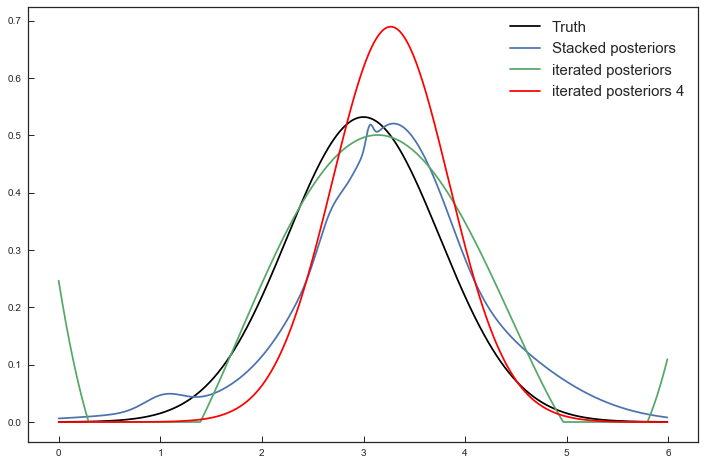

In [527]:
plt.figure(figsize=[12,8])
plt.plot(x,gdist,'k',label = 'Truth')
plt.plot(x,Pos,label = 'Stacked posteriors')
plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.plot(iterx4,iterpos4,'r',label = 'iterated posteriors 4')

plt.legend(fontsize = 15)

In [504]:
lzgrid = Gen_grid(lzDB,'Z')

In [531]:
X=metal

Pos = Stack_posteriors(lzgrid,X)
iterpos,iterx = Iterate_stack(lzgrid,X,20)
iterpos4,iterx4 = Iterative_stacking(lzgrid,X,resampling=500)


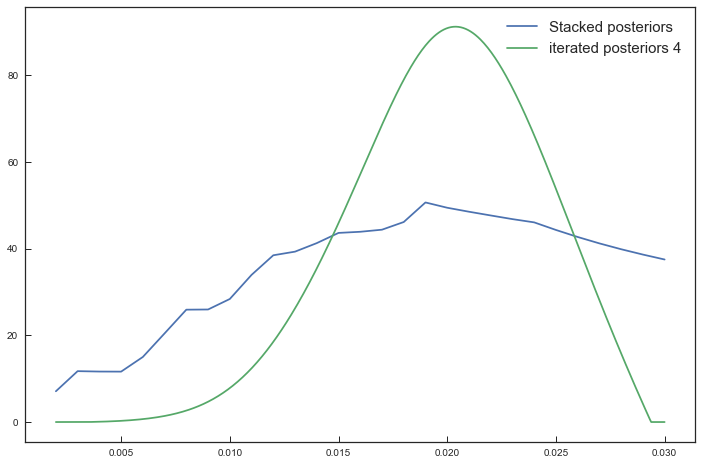

In [534]:
plt.figure(figsize=[12,8])
plt.plot(X,Pos,label = 'Stacked posteriors')
# plt.plot(iterx,iterpos,label = 'iterated posteriors')
plt.plot(iterx4,iterpos4,label = 'iterated posteriors 4')

plt.legend(fontsize = 15)

In [340]:
np.var(age)

2.6124999999999994

In [473]:
def Iterative_stacking(grid_o,x_o,iterations = 20,resampling = 1000):
    del_x = x_o[1] - x_o[0]

    ### resample
    x = np.linspace(x_o[0],x_o[-1],resampling)
    grid = np.zeros([len(grid_o),x.size])    
    for i in range(len(grid_o)):
        grid[i] = interp1d(x_o,grid_o[i])(x)
   
    ### select bandwidth
    H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    Fx = Fx/np.trapz(Fx,x)
    return Fx,x